In [1]:
import pickle
import os
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)

blue = '#00AEEF'
red = '#F15A2A'

In [2]:
from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, get_sample_from_num_swaps, test_network
from src.utils.general_old import get_selectivity, get_cos_sim_torch
from src.utils.plotting import compare_distributions_12
from Figure_6_utils import sensory_semantic_replay

In [3]:
from network_parameters import network_parameters


In [5]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [6]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf

recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "ctx", "mtl"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = []
recording_parameters["rate_connectivity"] = np.inf

num_episodes = 5
input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 5 * num_episodes
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [7]:

def episode_recall(net, ep, num_swaps):
    num_iterations = 10
    mtl_dense_corrupted =  get_sample_from_num_swaps(ep[:net.mtl_dense_size], num_swaps)
    mtl_0 = torch.zeros((net.mtl_size))
    mtl_0[:net.mtl_dense_size] = mtl_dense_corrupted
    mtl = mtl_0.clone()
    for iteration in range(num_iterations):
      mtl_hat = F.linear(net.mtl_mtl, mtl)
      mtl, _ = net.activation(mtl_hat, 'mtl')

    recall_dense = get_cos_sim_torch(mtl[:net.mtl_dense_size], ep[:net.mtl_dense_size])
    recall_sparse = get_cos_sim_torch(mtl[net.mtl_dense_size:], ep[net.mtl_dense_size:])
    recall = get_cos_sim_torch(mtl, ep)
    return mtl_0, mtl, recall_dense, recall_sparse, recall




def get_recalls(network):
    num_trials = 10
    recalls = []
    recalls_sparse = []
    recalls_dense = []
    for trial in range(num_trials):
        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=50
        )

        for episode in torch.stack(network.activity_recordings["mtl"], axis=0):
            mtl_0, mtl, recall_dense, recall_sparse, recall = episode_recall(network, episode, num_swaps=0)
            recalls.append(recall)
            recalls_sparse.append(recall_sparse)
            recalls_dense.append(recall_dense)

    return recalls, recalls_dense, recalls_sparse


def get_replays(network):

    def get_max_overlap(replayed, prototpyes):
        cos_sims = [get_cos_sim_torch(replayed, prototype) for prototype in prototpyes]
        max_sim = torch.max(torch.stack(cos_sims, dim=0))
        return max_sim.item()

    num_trials = 100
    num_replays = 5
    num_iterations = 10
    replays = []
    for trial in range(num_trials):
        network.init_recordings(recording_parameters)
        network.frozen = False
        network.activity_recordings_rate = 1
        network.connectivity_recordings_rate = np.inf

        input, input_episodes, input_latents, network = test_network(
            network, input_params, sleep=False, print_rate=50
        )


        for replay in range(num_replays):
            mtl = torch.randn(network.mtl_size)
            for iteration in range(num_iterations):
                mtl_hat = F.linear(network.mtl_mtl, mtl)
                mtl, _ = network.activation(mtl_hat, 'mtl')
            replays.append(get_max_overlap(mtl,torch.stack(network.activity_recordings["mtl"], axis=0)))

    return replays

In [8]:
network_intact = torch.load("checkpoints/network_5_blocked.pt", weights_only=False)

In [10]:
network_intact.init_recordings(recording_parameters)
network_intact.frozen = False
network_intact.activity_recordings_rate = 1
network_intact.connectivity_recordings_rate = np.inf


input, input_episodes, input_latents, network = test_network(
    network_intact, input_params, sleep=False, print_rate=50
)


0


In [11]:
mtl_dense_0 = torch.stack(network_intact.activity_recordings["mtl_dense"], axis=0)[network_intact.awake_indices][-1]
mtl_0 = torch.zeros(network_intact.mtl_size)
mtl_0[:network.mtl_dense_size] = mtl_dense_0
mtl = network.pattern_complete("mtl", mtl_0)

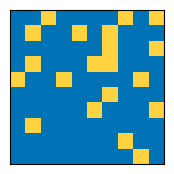

In [12]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(mtl_dense_0.reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/6b1.svg', dpi=300, transparent=True)

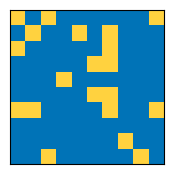

In [13]:
fig = plt.figure(figsize=(2, 2))
plt.imshow(mtl[:network.mtl_dense_size].reshape(-1, 10), cmap=blue_yellow)
plt.xticks([])
plt.yticks([])
plt.savefig('Figures_SVG/6b2.svg', dpi=300, transparent=True)

In [14]:
def test_network(net, input_params, sleep=False, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      if sleep:
        net.sleep()
  return input, input_episodes, input_latents, net

In [15]:

recalls_intact = get_recalls(network_intact)
replays_intact = get_replays(network_intact)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [16]:
network_scrambled = deepcopy(network_intact)

# Generate independent permutations for each row
perms = torch.argsort(torch.rand_like(network_scrambled.mtl_sparse_ctx), dim=1)
# Apply the permutations
network_scrambled.mtl_sparse_ctx = torch.gather(network_scrambled.mtl_sparse_ctx, dim=1, index=perms)
# Freeze ctx to mtl sparse connections
network_scrambled.mtl_sparse_ctx_lmbda = 0
network_scrambled.mtl_sparse_b[:] = -1

In [17]:

recalls_scrambled = get_recalls(network_scrambled)
replays_scrambled = get_replays(network_scrambled)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


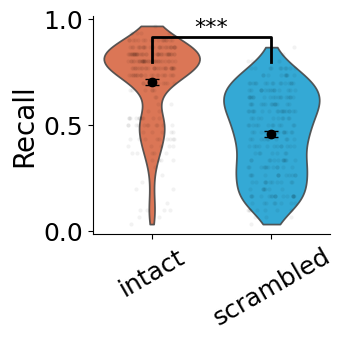

In [18]:
dist1 = ('intact', recalls_intact[0])
dist2 = ('scrambled', recalls_scrambled[0])

palette = {
    "intact": red, 
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Recall", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6c.svg', dpi=300, transparent=True)


/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


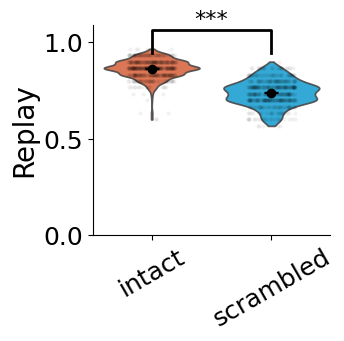

In [19]:
dist1 = ('intact', replays_intact)
dist2 = ('scrambled', replays_scrambled)

palette = {
    "intact": red,   # light blue
    "scrambled": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Replay", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()
plt.savefig('Figures_SVG/6e.svg', dpi=300, transparent=True)

In [20]:
num_episodes = 5
input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 200
input_params["mean_duration"] = 1
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

In [23]:
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0


In [24]:
mtl_sen_episodes = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.awake_indices][-200:]

In [25]:
mtl_semantic_episodes = torch.stack(network.activity_recordings["mtl_sparse"], axis=0)[network.awake_indices][-200:]

In [26]:
overlaps = []
overlap_latents = []

for episode_i, latent_i in zip(mtl_sen_episodes, input_latents.squeeze(0)):
    for episode_j, latent_j in zip(mtl_sen_episodes, input_latents.squeeze(0)):
        overlaps.append(get_cos_sim_torch(episode_i, episode_j))
        sim_latent = 0
        if latent_i[0] == latent_j[0]:
            sim_latent += 1
        if latent_i[1] == latent_j[1]:
            sim_latent += 1
        overlap_latents.append(sim_latent)


In [27]:
overlaps = []
overlap_latents = []

for episode_i, latent_i in zip(mtl_semantic_episodes, input_latents.squeeze(0)):
    for episode_j, latent_j in zip(mtl_semantic_episodes, input_latents.squeeze(0)):
        overlaps.append(get_cos_sim_torch(episode_i, episode_j))
        sim_latent = 0
        if latent_i[0] == latent_j[0]:
            sim_latent += 1
        if latent_i[1] == latent_j[1]:
            sim_latent += 1
        overlap_latents.append(sim_latent)


In [21]:
def get_recall(network):

    num_trials = 5
    num_episodes_range = [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000]
    num_swaps_range = [10]

    len_episode_range = len(num_episodes_range)
    len_swaps_range = len(num_swaps_range)

    # Allocate trial axis (first dim)
    recall_dense = torch.zeros((num_trials, len_episode_range, len_swaps_range))
    recall_sparse = torch.zeros((num_trials, len_episode_range, len_swaps_range))
    recall = torch.zeros((num_trials, len_episode_range, len_swaps_range))
    recall_only_dense = torch.zeros((num_trials, len_episode_range, len_swaps_range))

    for trial in range(num_trials):
        print(f"Trial {trial+1}/{num_trials}")
        for num_episodes_idx, num_episodes in enumerate(num_episodes_range):

            seed_everything(trial)

            input_params = {}
            input_params["num_days"] = 1
            input_params["day_length"] = 5 * num_episodes
            input_params["mean_duration"] = 5
            input_params["fixed_duration"] = True
            input_params["num_swaps"] = 2

            latent_specs = {}
            latent_specs["num"] = 2
            latent_specs["total_sizes"] = [50, 50]
            latent_specs["act_sizes"] = [10, 10]
            latent_specs["dims"] = [5, 5]
            latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
            input_params["latent_space"] = LatentSpace(**latent_specs)

            network.init_recordings(recording_parameters)
            network.frozen = False
            network.activity_recordings_rate = 1
            network.connectivity_recordings_rate = np.inf

            input, input_episodes, input_latents, network = test_network(
                network, input_params, sleep=False, print_rate=50
            )

            for num_swap_idx, num_swap in enumerate(num_swaps_range):
                rd = torch.zeros(input_params["day_length"])
                rs = torch.zeros(input_params["day_length"])
                r = torch.zeros(input_params["day_length"])
                for episode_idx, episode in enumerate(torch.stack(network.activity_recordings["mtl"], dim=0)[1:]):
                    _, _, rd[episode_idx], rs[episode_idx], r[episode_idx] = episode_recall(network, episode, num_swap)
                recall_dense[trial, num_episodes_idx, num_swap_idx] = rd.mean()
                recall_sparse[trial, num_episodes_idx, num_swap_idx] = rs.mean()
                recall[trial, num_episodes_idx, num_swap_idx] = r.mean()


    return recall_dense, recall_sparse, recall

In [22]:
recall_intact, recall_sparse_intact, recall_dense_intact  = get_recall(network_intact)
recall_scrambled, recall_sparse_scrambled, recall_dense_scrambled  = get_recall(network_scrambled)

Trial 1/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 2/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 3/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 4/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 5/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 1/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 2/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 3/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 4/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Trial 5/5
0
0
0
0
0
0
0
0
0
0
0
0
0
0


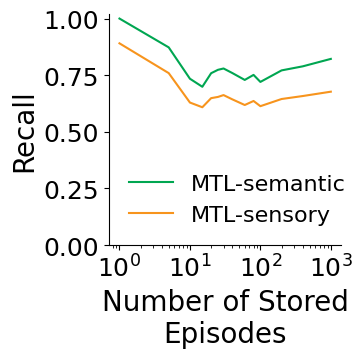

In [23]:
fig = plt.figure(figsize=(3, 3))
plt.plot(
    [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000],
    recall_sparse_intact.mean(axis=0),
    label="MTL-semantic",
    color=green
)
plt.plot(
    [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000],
    recall_dense_intact.mean(axis=0),
    label="MTL-sensory",
    color=orange
)
plt.legend(frameon=False, fontsize=16)
plt.xscale("log")
plt.yticks([0, 0.25, 0.5, 0.75, 1], fontsize=18)
plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d.svg', dpi=300, transparent=True)

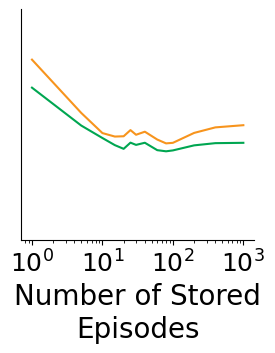

In [24]:
fig = plt.figure(figsize=((3, 3)))
plt.plot(
    [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000],
    recall_sparse_scrambled.mean(axis=0),
    label="MTL-semantic",
    color=green
)
plt.plot(
    [1, 5, 10, 15, 20, 25, 30, 40, 60, 80, 100, 200, 400, 1000],
    recall_dense_scrambled.mean(axis=0),
    label="MTL-sensory",
    color=orange
)
plt.xscale("log")
plt.yticks([], fontsize=18)
plt.ylim([0, 1])


plt.xticks(fontsize=18)
sns.despine()
plt.xlabel("Number of Stored\nEpisodes", fontsize=20)
#plt.ylabel("Recall", fontsize=20)

plt.savefig('Figures_SVG/6d2.svg', dpi=300, transparent=True)

In [26]:


os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")

num_cpu = 100
num_seeds = 50
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [27]:
experiment_params = [(network_parameters, recording_parameters, input_params, latent_specs, seed) for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results_list = pool.starmap(sensory_semantic_replay, experiment_params)

starting simulation - 1starting simulation - 2

starting simulation - 0
0
0
0
starting simulation - 3
starting simulation - 4
starting simulation - 5
starting simulation - 6
starting simulation - 7starting simulation - 8

starting simulation - 9starting simulation - 10

starting simulation - 11starting simulation - 12starting simulation - 13

starting simulation - 14

starting simulation - 15starting simulation - 16

starting simulation - 17starting simulation - 18

starting simulation - 20starting simulation - 21starting simulation - 19starting simulation - 22starting simulation - 23

starting simulation - 25
starting simulation - 24
starting simulation - 26
starting simulation - 27starting simulation - 29


starting simulation - 28

starting simulation - 31starting simulation - 30
starting simulation - 32starting simulation - 33starting simulation - 34starting simulation - 35
starting simulation - 36
starting simulation - 37
starting simulation - 38

starting simulation - 39starting 

In [28]:



def save_results(results_list, filename):


    results = {}
    results["selectivity_mtl_sparse"] = []
    results["accuracy_mtl_sparse_1"] = []
    results["accuracy_mtl_sparse_2"] = []


    for selectivity_mtl_sparse, accuracy_1, accuracy_2 in results_list:


        results["selectivity_mtl_sparse"].append(selectivity_mtl_sparse)
        results["accuracy_mtl_sparse_1"].append(accuracy_1)
        results["accuracy_mtl_sparse_2"].append(accuracy_2)

    with open('Data/{}'.format(filename), 'wb') as handle:
        pickle.dump(dict(results), handle, protocol=pickle.HIGHEST_PROTOCOL)


save_results(results_list, filename='fig_6_sensory_semantic.pickle')

In [29]:
with open('Data/{}'.format('fig_6_sensory_semantic.pickle'), 'rb') as handle:
    results = pickle.load(handle)

/home/aa10522/Desktop/sensory-semantic-episodes/src/utils/plotting.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=groups, y=data, inner=None, cut=0, alpha=0.9, palette=palette)


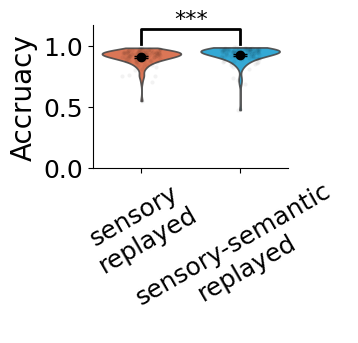

In [30]:


# Flatten arrays
acc_pre_c = np.array(results["accuracy_mtl_sparse_1"]).flatten()
acc_post_c = np.array(results["accuracy_mtl_sparse_2"]).flatten()


dist1 = ('sensory\nreplayed', acc_pre_c)
dist2 = ('sensory-semantic\nreplayed', acc_post_c)

palette = {
    "sensory\nreplayed": red,   # light blue
    "sensory-semantic\nreplayed": blue
}

compare_distributions_12(dist1, dist2, palette)
plt.ylabel("Accruacy", fontsize=20)
plt.xticks(fontsize=18, rotation=30)
plt.yticks([0, 0.5, 1], fontsize=18)
plt.tight_layout()
sns.despine()

In [31]:
median_seed = np.argsort(np.array(results["accuracy_mtl_sparse_2"]).mean(axis=1))[num_seeds//2]
best_seed = np.argsort(np.array(results["accuracy_mtl_sparse_2"]).mean(axis=1))[-1]

In [32]:
network, input, input_latents, input_episodes, ordered_indices_ctx, ordered_indices_mtl_dense, ordered_indices_mtl_sparse, selectivity_ctx, selectivity_mtl_dense, selectivity_mtl_sparse, accuracy = sensory_semantic_replay(network_parameters, recording_parameters, input_params, latent_specs, seed=int(best_seed), get_network=True)
network.selectivity_ctx = selectivity_ctx
network.ordered_indices_ctx = ordered_indices_ctx
network.ordered_indices_mtl_dense = ordered_indices_mtl_dense
network.ordered_indices_mtl_sparse = ordered_indices_mtl_sparse

torch.save(network, "checkpoints/network_6_best.pt")

starting simulation - 6
0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
0
50
0
50
100
150
200
250
300
350
400
450
0
50


In [37]:

#network_median = torch.load("checkpoints/network_6_median.pt", weights_only=False)
network = torch.load("checkpoints/network_6_best.pt", weights_only=False)

In [32]:
plt.hist(network_median.selectivity_ctx[network_median.ordered_indices_ctx[:100]].max(axis=1)[0])

AttributeError: 'SSCNetwork' object has no attribute 'selectivity_ctx'

False